In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel.utils.inliner import inline
from tqdm import tqdm
from collections import OrderedDict
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model import model_6_v1 as Model
except:
    from .model import model_6_v1 as Model

from pathlib import Path
import multiprocessing
from pprint import pprint
import torch
import math
from matplotlib import pyplot as plt
import yaml

In [4]:
from sklearn.metrics import auc

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

Current device  >>  cuda


In [6]:
def visualize( model_obj, x1,x2 ):
   
    from sklearn.decomposition import TruncatedSVD
    try :
        %matplotlib inline
    except:
        pass
    import matplotlib.pyplot as plt
    
    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)

    plt.figure(figsize=[10,10])
    plt.scatter(x3[:len(x1),0], x3[:len(x1),1], c='g',alpha=0.95)
    plt.scatter(x3[len(x1):,0], x3[len(x1):,1], c='r',alpha=0.35)
    plt.show()
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter( x3[:len(x1),0], x3[:len(x1),1], x3[:len(x1),2], c ='g',alpha=0.95 , marker='^')
    ax.scatter( x3[len(x1):,0], x3[len(x1):,1], x3[len(x1):,2], c ='r',alpha=0.35 , marker='v')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    return

In [7]:
def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'
    
    with open(config_file, 'r') as fh :
        config = yaml.safe_load(fh)
    config = config[data_set]
    latent_dim = config['ae_latent_dimension']

    data_dict, meta_data_df = data_fetcher.get_data(data_set,True, 0.1)

    # discrete_columns : { column_name : num_categories }
    discrete_dims = OrderedDict ({k: v for k, v in zip(list(meta_data_df['column']), list(meta_data_df['dimension']))})
    num_discrete_columns = len(discrete_dims)
    count_discrete_dims = 0
    for val in discrete_dims.values():
        if val == 2:
            count_discrete_dims += 1
        else:
            count_discrete_dims += val
            
    real_dims = len(data_dict['train'].columns) - count_discrete_dims

    # ---------------
    # encoder_structure_config['ip_layers']
    # Format :
    # [ 'emb|onehot', num_categories, [ embedding dimension ]
    # ---------------
    encoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'encoder_FCN_to_latent': config['encoder_FCN_to_latent'],
        'ae_latent_dimension' :  config['ae_latent_dimension'],
        'encoder_discrete_xform' : config['encoder_discrete_xform'],
        'encoder_real_xform' : config['encoder_real_xform']
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'decoder_FC_from_latent': config['decoder_FC_from_latent'],
        'decoder_discrete_xform' : config['decoder_discrete_xform'],
        'decoder_real_xform' : config['decoder_real_xform'],
        'ae_latent_dimension': config['ae_latent_dimension']
    }

    # ================
    # Format decoder_field_layers:
    # { idx : [[dim1,dim2], op_activation ]
    # ================
    loss_structure_config = {
        'discrete_dims' : discrete_dims,
        'real_loss_func': config['real_loss_func'],
        'real_dims':  real_dims
    }

    return encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim

encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config('gureKDD')
pprint(encoder_structure_config)
pprint(decoder_structure_config)

{'ae_latent_dimension': 10,
 'discrete_dims': OrderedDict([('protocol_type', 3),
                               ('service', 23),
                               ('flag', 12),
                               ('land', 2),
                               ('logged_in', 2),
                               ('root_shell', 2),
                               ('is_hot_login', 2),
                               ('is_guest_login', 2)]),
 'encoder_FCN_to_latent': {'activation': 'tanh', 'dims': [40, 32, 16]},
 'encoder_discrete_xform': None,
 'encoder_real_xform': {'activation': 'tanh', 'dims': [8]},
 'real_dims': 33}
{'ae_latent_dimension': 10,
 'decoder_FC_from_latent': {'activation': 'tanh', 'dims': [16, 32]},
 'decoder_discrete_xform': {'flag': {'activation': 'tanh', 'dims': None},
                            'is_guest_login': {'activation': 'tanh',
                                               'dims': None},
                            'land': {'activation': 'tanh', 'dims': None},
                

In [8]:
loss_structure_config


{'discrete_dims': OrderedDict([('protocol_type', 3),
              ('service', 23),
              ('flag', 12),
              ('land', 2),
              ('logged_in', 2),
              ('root_shell', 2),
              ('is_hot_login', 2),
              ('is_guest_login', 2)]),
 'real_loss_func': 'smooth_l1',
 'real_dims': 33}

In [9]:
# ======================================= #
import model_data_fetcher
# ======================================= #



num_anomaly_sets = 5
anomaly_ratio = 0.10

pos, neg_x, data_dict = model_data_fetcher.fetch_model_data('gureKDD',num_anom_sets=num_anomaly_sets,anomaly_ratio=anomaly_ratio)

train_X = data_dict['train']


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 100000/100000 [09:19<00:00, 178.68it/s]


Size {:.3f} 36.675963401794434  MB 
Size {:.3f} 564.4627542495728  MB 
>  1000000 166666


In [10]:
train_X.shape

(70000, 76)

In [11]:
try:
    from model import model_6_v1_container as Model
except:
    from .model import model_6_v1_container as Model
    
ae_model =  Model(
    DEVICE,
    latent_dim,
    encoder_structure_config,
    decoder_structure_config,
    loss_structure_config,
    batch_size=256,
    learning_rate=0.0005,
    max_gamma = 10,
    fc_dropout=0.1,
    ae_dropout=0.3,
    burn_in_epochs=15,
    phase_2_epochs=10,
    phase_3_epochs=15
)

print(ae_model.network_module)

split schema  [3, 23, 12, 1, 1, 1, 1, 1, 33]
Loss structure config {'discrete_dims': OrderedDict([('protocol_type', 3), ('service', 23), ('flag', 12), ('land', 2), ('logged_in', 2), ('root_shell', 2), ('is_hot_login', 2), ('is_guest_login', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 33}
 Loss module split schema  [3, 23, 12, 1, 1, 1, 1, 1, 33]
Normal(loc: torch.Size([10]), scale: torch.Size([10]))
model_6_v1(
  (ae_module): AE(
    (encoder): AE_encoder(
      (input_x_form_layers): ModuleList(
        (0): Identity()
        (1): Identity()
        (2): Identity()
        (3): Identity()
        (4): Identity()
        (5): Identity()
        (6): Identity()
        (7): Identity()
        (8): Sequential(
          (0): Linear(in_features=33, out_features=8, bias=True)
          (1): Tanh()
        )
      )
      (FC_z): Sequential(
        (0): Linear(in_features=51, out_features=40, bias=True)
        (1): Dropout(p=0.3, inplace=False)
        (2): Tanh()
        (3): Linea

In [12]:
pos.shape

(70000, 76)

In [13]:
neg_x.shape

(70000, 10, 76)

In [14]:
losses = ae_model.train_model(
    pos, 
    neg_x
)

  0%|          | 0/40 [00:00<?, ?it/s]

 Epoch 1 Batch 0 Loss 43.8156 || AE 43.8156 1.4056 
 Epoch 1 Batch 100 Loss 37.0513 || AE 37.0513 1.4084 
 Epoch 1 Batch 200 Loss 31.8798 || AE 31.8798 1.4187 


  2%|▎         | 1/40 [00:16<10:50, 16.67s/it]

Epoch loss :: 35.903248
 Epoch 2 Batch 0 Loss 31.2342 || AE 31.2342 1.4168 
 Epoch 2 Batch 100 Loss 30.8023 || AE 30.8023 1.4182 
 Epoch 2 Batch 200 Loss 30.5445 || AE 30.5445 1.4173 


  5%|▌         | 2/40 [00:31<10:12, 16.12s/it]

Epoch loss :: 30.765347
 Epoch 3 Batch 0 Loss 30.6024 || AE 30.6024 1.4150 
 Epoch 3 Batch 100 Loss 30.4618 || AE 30.4618 1.4162 
 Epoch 3 Batch 200 Loss 30.4003 || AE 30.4003 1.4178 


  8%|▊         | 3/40 [00:45<09:35, 15.57s/it]

Epoch loss :: 30.433315
 Epoch 4 Batch 0 Loss 30.2987 || AE 30.2987 1.4159 
 Epoch 4 Batch 100 Loss 30.3074 || AE 30.3074 1.4207 
 Epoch 4 Batch 200 Loss 30.4529 || AE 30.4529 1.4145 


 10%|█         | 4/40 [00:59<09:04, 15.12s/it]

Epoch loss :: 30.330952
 Epoch 5 Batch 0 Loss 30.3514 || AE 30.3514 1.4192 
 Epoch 5 Batch 100 Loss 30.4744 || AE 30.4744 1.4143 
 Epoch 5 Batch 200 Loss 30.1930 || AE 30.1930 1.4191 


 12%|█▎        | 5/40 [01:14<08:40, 14.88s/it]

Epoch loss :: 30.283752
 Epoch 6 Batch 0 Loss 30.2060 || AE 30.2060 1.4170 
 Epoch 6 Batch 100 Loss 30.3124 || AE 30.3124 1.4170 
 Epoch 6 Batch 200 Loss 30.1427 || AE 30.1427 1.4095 


 15%|█▌        | 6/40 [01:28<08:20, 14.71s/it]

Epoch loss :: 30.257341
 Epoch 7 Batch 0 Loss 30.3388 || AE 30.3388 1.4170 
 Epoch 7 Batch 100 Loss 30.1685 || AE 30.1685 1.4201 
 Epoch 7 Batch 200 Loss 30.1264 || AE 30.1264 1.4169 


 18%|█▊        | 7/40 [01:43<08:12, 14.93s/it]

Epoch loss :: 30.24037
 Epoch 8 Batch 0 Loss 30.1673 || AE 30.1673 1.4143 
 Epoch 8 Batch 100 Loss 30.1870 || AE 30.1870 1.4120 
 Epoch 8 Batch 200 Loss 30.0909 || AE 30.0909 1.4144 


 20%|██        | 8/40 [02:00<08:09, 15.29s/it]

Epoch loss :: 30.229464
 Epoch 9 Batch 0 Loss 29.9462 || AE 29.9462 1.4171 
 Epoch 9 Batch 100 Loss 30.2314 || AE 30.2314 1.4126 
 Epoch 9 Batch 200 Loss 30.0962 || AE 30.0962 1.4200 


 22%|██▎       | 9/40 [02:16<08:01, 15.53s/it]

Epoch loss :: 30.221594
 Epoch 10 Batch 0 Loss 30.1988 || AE 30.1988 1.4205 
 Epoch 10 Batch 100 Loss 30.2299 || AE 30.2299 1.4156 
 Epoch 10 Batch 200 Loss 30.2518 || AE 30.2518 1.4174 


 25%|██▌       | 10/40 [02:33<07:59, 15.98s/it]

Epoch loss :: 30.215553
 Epoch 11 Batch 0 Loss 30.0741 || AE 30.0741 1.4144 
 Epoch 11 Batch 100 Loss 30.2128 || AE 30.2128 1.4170 
 Epoch 11 Batch 200 Loss 30.3038 || AE 30.3038 1.4162 


 28%|██▊       | 11/40 [02:49<07:49, 16.18s/it]

Epoch loss :: 30.211052
 Epoch 12 Batch 0 Loss 30.3487 || AE 30.3487 1.4207 
 Epoch 12 Batch 100 Loss 30.2134 || AE 30.2134 1.4189 
 Epoch 12 Batch 200 Loss 30.1281 || AE 30.1281 1.4165 


 30%|███       | 12/40 [03:05<07:29, 16.07s/it]

Epoch loss :: 30.207716
 Epoch 13 Batch 0 Loss 30.0712 || AE 30.0712 1.4136 
 Epoch 13 Batch 100 Loss 30.0725 || AE 30.0725 1.4228 
 Epoch 13 Batch 200 Loss 30.1535 || AE 30.1535 1.4123 


 32%|███▎      | 13/40 [03:20<07:05, 15.74s/it]

Epoch loss :: 30.204775
 Epoch 14 Batch 0 Loss 30.3158 || AE 30.3158 1.4182 
 Epoch 14 Batch 100 Loss 30.3558 || AE 30.3558 1.4152 
 Epoch 14 Batch 200 Loss 30.0876 || AE 30.0876 1.4167 


 35%|███▌      | 14/40 [03:35<06:43, 15.52s/it]

Epoch loss :: 30.202896
 Epoch 15 Batch 0 Loss 1.4173 || AE 30.2304 1.4173 
 Epoch 15 Batch 100 Loss 1.3901 || AE 30.2229 1.3901 
 Epoch 15 Batch 200 Loss 1.3866 || AE 30.1632 1.3866 


 38%|███▊      | 15/40 [03:53<06:48, 16.35s/it]

Epoch loss :: 1.3914827
 Epoch 16 Batch 0 Loss 15.3046 || AE 30.2639 4.1711 
 Epoch 16 Batch 100 Loss 14.3858 || AE 30.2410 3.2607 
 Epoch 16 Batch 200 Loss 14.0034 || AE 30.0513 2.9482 


 40%|████      | 16/40 [04:11<06:38, 16.61s/it]

Epoch loss :: 12.720775
 Epoch 17 Batch 0 Loss 6.9323 || AE 30.3553 2.8242 
 Epoch 17 Batch 100 Loss 6.8617 || AE 30.1910 2.7758 
 Epoch 17 Batch 200 Loss 6.8587 || AE 30.4118 2.7429 


 42%|████▎     | 17/40 [04:29<06:31, 17.00s/it]

Epoch loss :: 5.472238
 Epoch 18 Batch 0 Loss 4.2443 || AE 30.3878 2.7314 
 Epoch 18 Batch 100 Loss 4.2506 || AE 30.0817 2.7529 
 Epoch 18 Batch 200 Loss 4.2323 || AE 30.2261 2.7274 


 45%|████▌     | 18/40 [04:48<06:27, 17.60s/it]

Epoch loss :: 2.8711445
 Epoch 19 Batch 0 Loss 3.3143 || AE 30.0946 2.7631 
 Epoch 19 Batch 100 Loss 3.2676 || AE 30.2218 2.7141 
 Epoch 19 Batch 200 Loss 3.2938 || AE 30.1724 2.7411 


 48%|████▊     | 19/40 [05:05<06:08, 17.53s/it]

Epoch loss :: 1.9182895
 Epoch 20 Batch 0 Loss 2.2852 || AE 30.3158 2.0809 
 Epoch 20 Batch 100 Loss 1.0217 || AE 30.2714 0.8178 
 Epoch 20 Batch 200 Loss 0.8304 || AE 30.2506 0.6265 


 50%|█████     | 20/40 [05:22<05:48, 17.42s/it]

Epoch loss :: 0.6078896
 Epoch 21 Batch 0 Loss 0.6181 || AE 30.2250 0.5432 
 Epoch 21 Batch 100 Loss 0.5287 || AE 30.2263 0.4538 
 Epoch 21 Batch 200 Loss 0.4631 || AE 30.1149 0.3884 


 52%|█████▎    | 21/40 [05:40<05:33, 17.56s/it]

Epoch loss :: 0.29657173
 Epoch 22 Batch 0 Loss 0.4362 || AE 30.2552 0.4086 
 Epoch 22 Batch 100 Loss 0.3513 || AE 30.3372 0.3236 
 Epoch 22 Batch 200 Loss 0.3210 || AE 30.3286 0.2934 


 55%|█████▌    | 22/40 [05:57<05:11, 17.33s/it]

Epoch loss :: 0.1856857
 Epoch 23 Batch 0 Loss 0.2775 || AE 30.1540 0.2674 
 Epoch 23 Batch 100 Loss 0.2526 || AE 30.1366 0.2424 
 Epoch 23 Batch 200 Loss 0.2224 || AE 30.1632 0.2122 


 57%|█████▊    | 23/40 [06:15<05:01, 17.71s/it]

Epoch loss :: 0.1314276
 Epoch 24 Batch 0 Loss 0.2062 || AE 30.3464 0.2024 
 Epoch 24 Batch 100 Loss 0.2021 || AE 30.2911 0.1983 
 Epoch 24 Batch 200 Loss 0.1764 || AE 30.1971 0.1726 


 60%|██████    | 24/40 [06:33<04:40, 17.55s/it]

Epoch loss :: 0.100791134
 Epoch 25 Batch 0 Loss 0.1679 || AE 30.1720 0.1679 
 Epoch 25 Batch 100 Loss 0.1424 || AE 30.1774 0.1424 
 Epoch 25 Batch 200 Loss 0.1900 || AE 30.3284 0.1900 


 62%|██████▎   | 25/40 [06:50<04:24, 17.62s/it]

Epoch loss :: 0.13696343
 Epoch 26 Batch 0 Loss 0.0979 || AE 30.1725 0.0979 
 Epoch 26 Batch 100 Loss 0.0961 || AE 30.2240 0.0961 
 Epoch 26 Batch 200 Loss 0.0717 || AE 30.1709 0.0717 


 65%|██████▌   | 26/40 [07:11<04:18, 18.49s/it]

Epoch loss :: 0.093832724
 Epoch 27 Batch 0 Loss 0.0776 || AE 30.3077 0.0776 
 Epoch 27 Batch 100 Loss 0.0616 || AE 30.1310 0.0616 
 Epoch 27 Batch 200 Loss 0.0526 || AE 30.1290 0.0526 


 68%|██████▊   | 27/40 [07:29<04:00, 18.47s/it]

Epoch loss :: 0.07154445
 Epoch 28 Batch 0 Loss 0.0482 || AE 30.0771 0.0482 
 Epoch 28 Batch 100 Loss 0.0473 || AE 30.1701 0.0473 
 Epoch 28 Batch 200 Loss 0.1285 || AE 30.3681 0.1285 


 70%|███████   | 28/40 [07:47<03:38, 18.23s/it]

Epoch loss :: 0.059283305
 Epoch 29 Batch 0 Loss 0.0350 || AE 30.2642 0.0350 
 Epoch 29 Batch 100 Loss 0.0356 || AE 30.3521 0.0356 
 Epoch 29 Batch 200 Loss 0.0331 || AE 30.2044 0.0331 


 72%|███████▎  | 29/40 [08:04<03:16, 17.85s/it]

Epoch loss :: 0.051904287
 Epoch 30 Batch 0 Loss 0.1604 || AE 30.3620 0.1604 
 Epoch 30 Batch 100 Loss 0.0340 || AE 30.1796 0.0340 
 Epoch 30 Batch 200 Loss 0.0340 || AE 30.2102 0.0340 


 75%|███████▌  | 30/40 [08:21<02:56, 17.63s/it]

Epoch loss :: 0.047573224
 Epoch 31 Batch 0 Loss 0.0345 || AE 30.3128 0.0345 
 Epoch 31 Batch 100 Loss 0.0243 || AE 30.1935 0.0243 
 Epoch 31 Batch 200 Loss 0.0265 || AE 30.0780 0.0265 


 78%|███████▊  | 31/40 [08:39<02:39, 17.69s/it]

Epoch loss :: 0.04198068
 Epoch 32 Batch 0 Loss 0.0238 || AE 30.1315 0.0238 
 Epoch 32 Batch 100 Loss 0.0186 || AE 30.2239 0.0186 
 Epoch 32 Batch 200 Loss 0.0247 || AE 30.2334 0.0247 


 80%|████████  | 32/40 [08:56<02:20, 17.54s/it]

Epoch loss :: 0.041627318
 Epoch 33 Batch 0 Loss 0.0271 || AE 30.1365 0.0271 
 Epoch 33 Batch 100 Loss 0.0203 || AE 30.1210 0.0203 
 Epoch 33 Batch 200 Loss 0.0244 || AE 30.2203 0.0244 


 82%|████████▎ | 33/40 [09:16<02:08, 18.37s/it]

Epoch loss :: 0.040979978
 Epoch 34 Batch 0 Loss 0.1831 || AE 30.3955 0.1831 
 Epoch 34 Batch 100 Loss 0.2732 || AE 30.5398 0.2732 
 Epoch 34 Batch 200 Loss 0.0151 || AE 30.2236 0.0151 


 85%|████████▌ | 34/40 [09:35<01:50, 18.36s/it]

Epoch loss :: 0.03846633
 Epoch 35 Batch 0 Loss 0.0133 || AE 30.2027 0.0133 
 Epoch 35 Batch 100 Loss 0.0146 || AE 30.2294 0.0146 
 Epoch 35 Batch 200 Loss 0.0983 || AE 30.2362 0.0983 


 88%|████████▊ | 35/40 [09:52<01:31, 18.20s/it]

Epoch loss :: 0.03908115
 Epoch 36 Batch 0 Loss 0.0202 || AE 30.2305 0.0202 
 Epoch 36 Batch 100 Loss 0.0157 || AE 30.2171 0.0157 
 Epoch 36 Batch 200 Loss 0.0162 || AE 30.3134 0.0162 


 90%|█████████ | 36/40 [10:10<01:12, 18.09s/it]

Epoch loss :: 0.036114074
 Epoch 37 Batch 0 Loss 0.0182 || AE 30.1660 0.0182 
 Epoch 37 Batch 100 Loss 0.0117 || AE 30.2372 0.0117 
 Epoch 37 Batch 200 Loss 0.0119 || AE 30.2694 0.0119 


 92%|█████████▎| 37/40 [10:29<00:54, 18.19s/it]

Epoch loss :: 0.039415076
 Epoch 38 Batch 0 Loss 0.0117 || AE 30.1954 0.0117 
 Epoch 38 Batch 100 Loss 0.0141 || AE 30.2117 0.0141 
 Epoch 38 Batch 200 Loss 0.0124 || AE 30.2143 0.0124 


 95%|█████████▌| 38/40 [10:49<00:37, 18.69s/it]

Epoch loss :: 0.037318062
 Epoch 39 Batch 0 Loss 0.0125 || AE 30.1995 0.0125 
 Epoch 39 Batch 100 Loss 0.0189 || AE 30.2184 0.0189 
 Epoch 39 Batch 200 Loss 0.0096 || AE 30.1169 0.0096 


 98%|█████████▊| 39/40 [11:08<00:18, 18.87s/it]

Epoch loss :: 0.03944143
 Epoch 40 Batch 0 Loss 0.0086 || AE 30.1296 0.0086 
 Epoch 40 Batch 100 Loss 0.0089 || AE 30.1075 0.0089 
 Epoch 40 Batch 200 Loss 0.2467 || AE 30.4922 0.2467 


100%|██████████| 40/40 [11:28<00:00, 17.20s/it]

Epoch loss :: 0.039902236


In [15]:
data_dict['anom_1'].values.shape

(3000, 76)

In [17]:
def test_eval():
    global data_dict
    global ae_model
    global num_anomaly_sets
   
    test_norm_X = data_dict['test']


    auc_list = []
    ae_model.mode = 'test'
    def _normalize_(val, _min,_max):
        return (val -_min)/(_max - _min)

    for idx in range(1, num_anomaly_sets+1):
        key = 'anom_'+str(idx)
        test_anom_df = data_dict[key]
        test_anom_X = test_anom_df.values
        x1 = test_norm_X
        x2 = test_anom_X


        x1_scores = ae_model.get_score(x1)
        x2_scores = ae_model.get_score(x2)

        res_data = []
        labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
        _scores = np.concatenate([x1_scores, x2_scores],axis=0)

        for i,j in zip(_scores, labels):
            res_data.append((i[0],j))

        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        res_df = res_df.sort_values(by=['score'],ascending= True)


        _max = max(res_df['score'])
        _min = min(res_df['score'])

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        _max = max(res_df['score'])
        _min = min(res_df['score'])

        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _min + step
        thresh = round(thresh,3)
        num_anomalies = x2.shape[0]
        print('Num anomalies',num_anomalies )
        P = []
        R = [0]

        while thresh <= _max:

            sel = res_df.loc[res_df['score'] <= thresh]
            if len(sel) == 0 :
                thresh += step
                continue

            correct = sel.loc[sel['label'] == 0 ]

            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies

            P.append(prec)
            R.append(rec)
            thresh += step
            thresh = round(thresh,3)

        P = [P[0]] + P
        pr_auc = auc( R, P)
        pr_auc = auc( R, P)

        plt.figure(figsize=[8,6])
        plt.plot(R,P)
        plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
        plt.xlabel('Recall',fontsize=15)
        plt.ylabel('Precision',fontsize=15)
        plt.show()

        print("AUC : {:0.4f} ".format(pr_auc))
        auc_list.append(pr_auc)

    print(' Mean AUC ', np.mean(auc_list))
    print(' AUC std ', np.std(auc_list)) 
    return auc_list

Num anomalies 3000


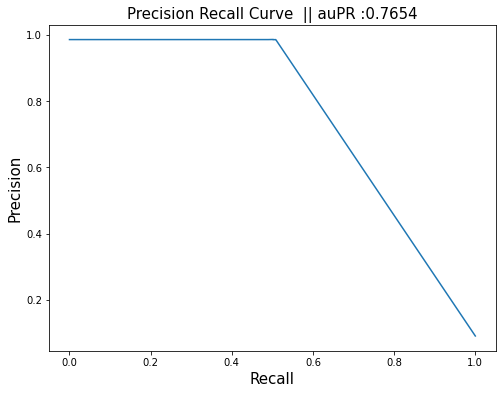

AUC : 0.7654 
Num anomalies 3000


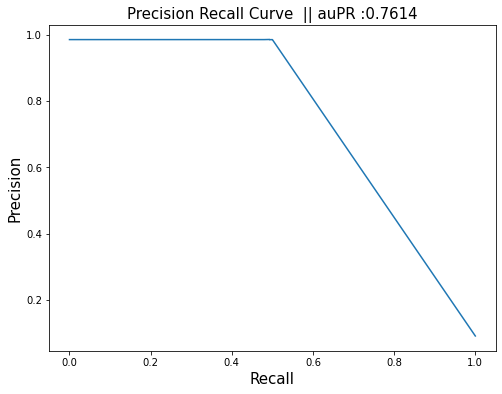

AUC : 0.7614 
Num anomalies 3000


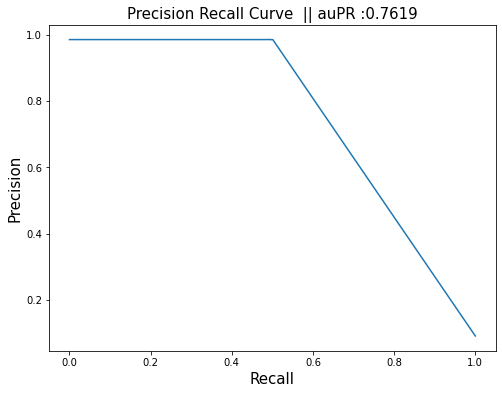

AUC : 0.7619 
Num anomalies 3000


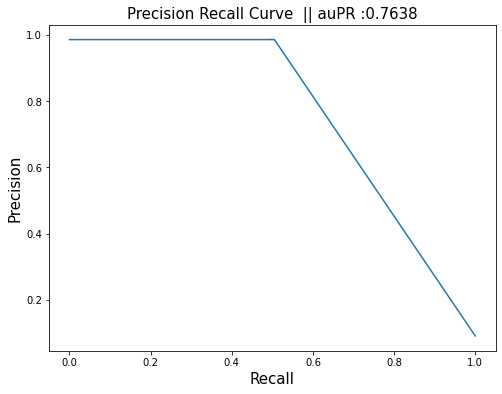

AUC : 0.7638 
Num anomalies 3000


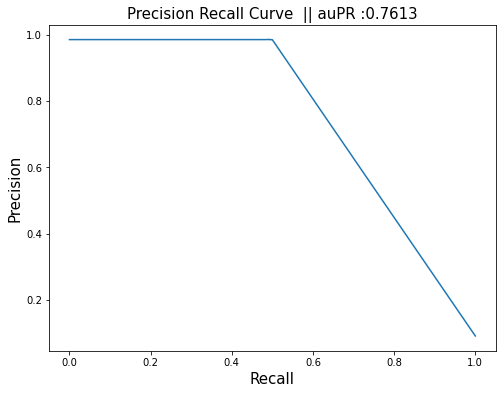

AUC : 0.7613 
 Mean AUC  0.7627547529497655
 AUC std  0.0015845668890226803


[0.7653678627615389,
 0.7614243979587885,
 0.7619142137491742,
 0.7637889917777319,
 0.7612782985015933]

In [19]:
test_eval()

Num anomalies 6432


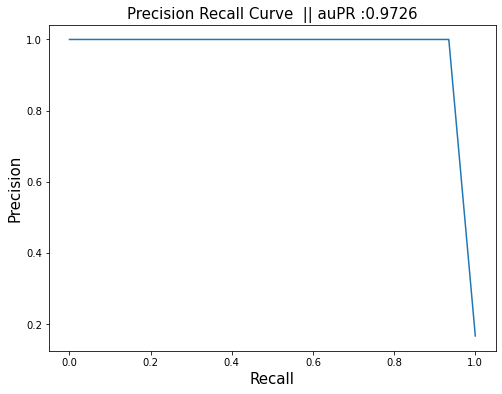

AUC : 0.9726 
Num anomalies 6432


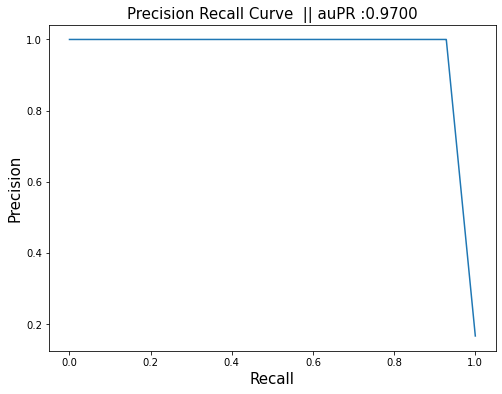

AUC : 0.9700 
Num anomalies 6432


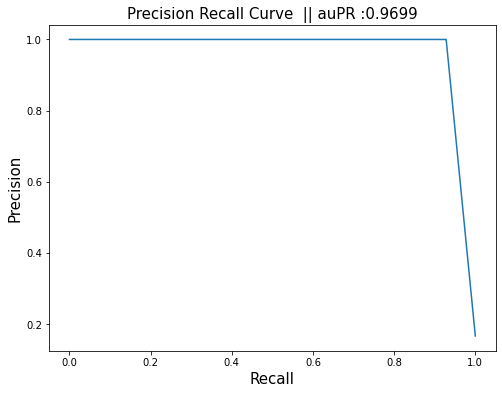

AUC : 0.9699 
Num anomalies 6432


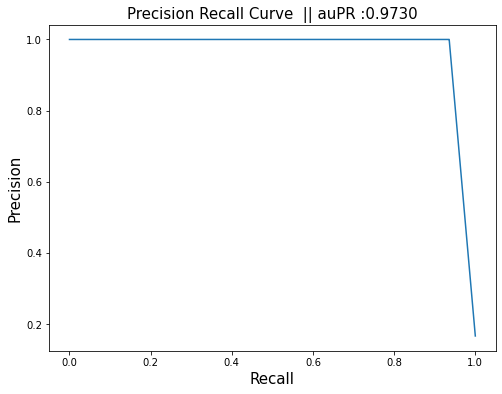

AUC : 0.9730 
Num anomalies 6432


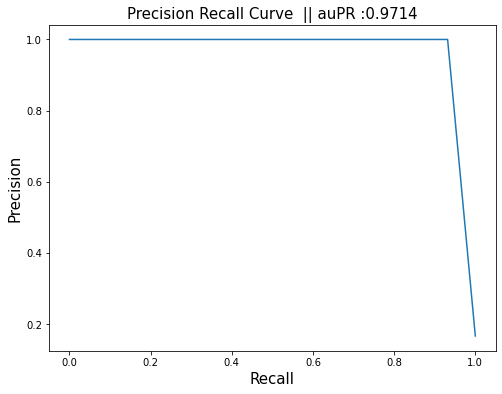

AUC : 0.9714 
 Mean AUC  0.9713985325851006
 AUC std  0.0012815641498309304


[0.9726295292103986,
 0.9700379996442805,
 0.9699080678319298,
 0.9730184540613853,
 0.9713986121775087]

In [21]:
test_eval()

# =========================================

In [72]:

test_norm_X = data_dict['test']

In [73]:
test_anom_df = data_dict['anom_1']
test_anom_X = test_anom_df.values
x1 = test_norm_X
x2 = test_anom_X

In [74]:
# pos,neg = model_data_fetcher.fetch_model_data('kddcup')

In [75]:

x0 = data_dict['train']

In [76]:
neg_x.shape

(70000, 10, 74)

In [77]:
neg1 = np.reshape(neg_x,[ neg_x.shape[0]* neg_x.shape[1] , neg_x.shape[2]])
np.random.shuffle(neg1)
neg1.shape

(700000, 74)

In [84]:
x3 = neg1[:50000]

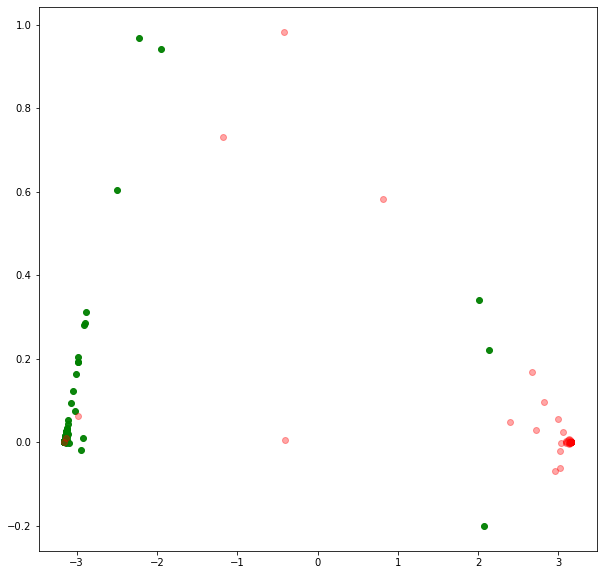

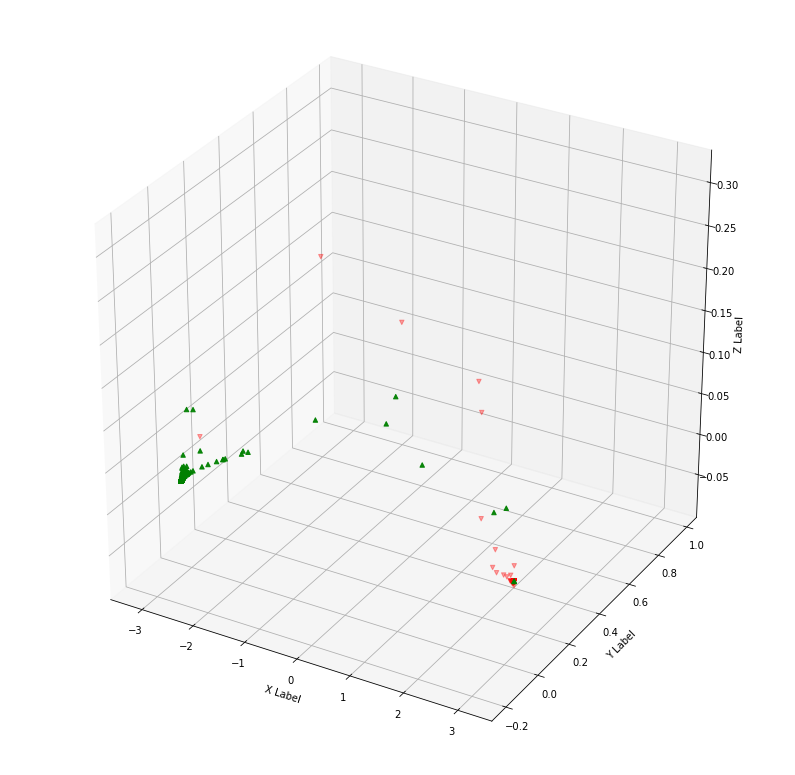

In [86]:
visualize( ae_model, x1, x3 )

In [87]:
ae_model.mode = 'test'

x1_scores = ae_model.get_score(x1)
x2_scores = ae_model.get_score(x2)

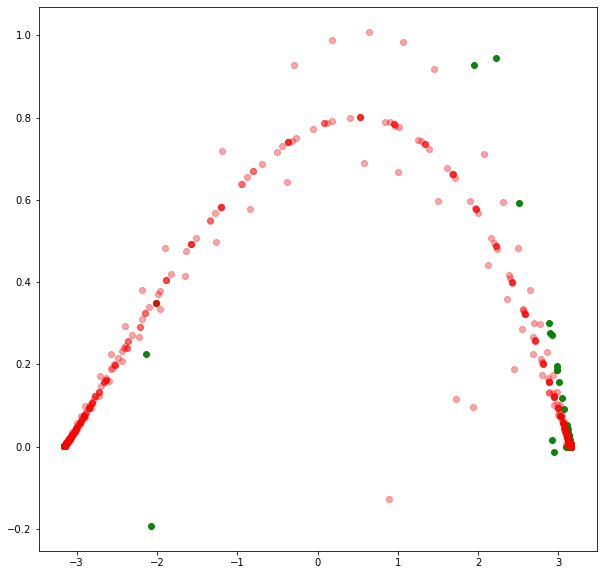

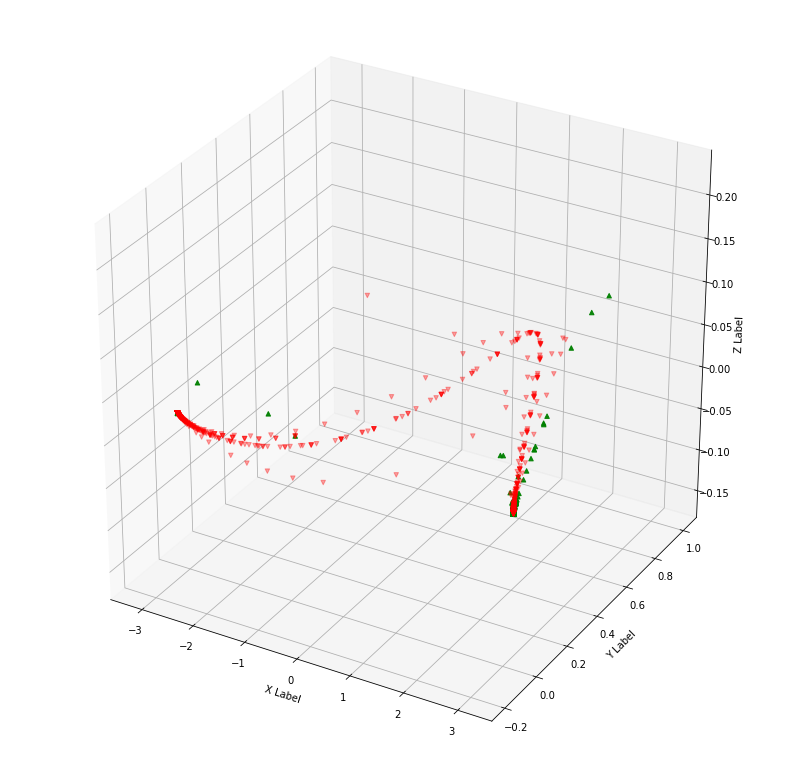

In [89]:
visualize( ae_model, x1, x2 )

In [43]:
x3_scores = ae_model.get_score(x3)
np.min(x3_scores), np.median(x3_scores), np.max(x3_scores)

(0.00030122657, 0.00030123346, 0.00030840922)

In [44]:
def _normalize_(val, _min,_max):
    return (val -_min)/(_max - _min)

In [45]:
import matplotlib.pyplot  as plt

In [46]:
# plt.boxplot(x1_scores)
# plt.show()
np.min(x2_scores), np.median(x2_scores), np.max(x2_scores)

(0.0003012303, 0.00030127252, 0.99995387)

Size:  train_df 75040 , test_df 32161, anomaly data 97278, Req anomalies 6432


 Mean AUC  0.9833125171695484
 AUC std  0.0006043721095057238


In [337]:
a = torch.FloatTensor(np.random.random([512,1,4]))
a.shape

Current device  >>  cuda


torch.Size([512, 1, 4])

In [341]:
a.squeeze(1).squeeze(1).shape

torch.Size([512, 4])

In [3]:
# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)

In [35]:
from sklearn.datasets.samples_generator import make_blobs
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [82]:
centers = [(-5, -5, -6), (5, 5,0),(.25,1.25,2)]
cluster_std = [0.25,1.25,1.75]

X, y = make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=3, random_state=1)

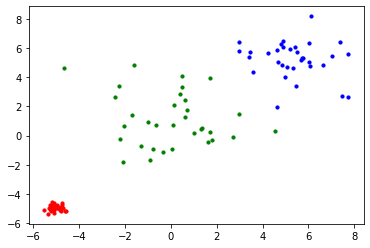

In [83]:
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red",  s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="blue", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green",  s=10, label="Cluster1")


In [100]:
# Prepare initial centers using K-Means++ method.

def x_means(
    X,
    num_init_clusters = 8,
    visualize = True
):
    from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
    from pyclustering.cluster.xmeans import xmeans
    from pyclustering.cluster import cluster_visualizer
    from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
    from pyclustering.cluster import cluster_visualizer_multidim
    
    X = list(X)
    
    initial_centers = kmeans_plusplus_initializer(
        X, 
        amount_initial_centers
       
    ).initialize()

    start_centers = kmeans_plusplus_initializer(X, num_init_clusters).initialize()
   
    xmeans_instance = xmeans(X, start_centers, 20, ccore=True,  criterion = 0)
        

    # Run cluster analysis and obtain results.
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    centers = xmeans_instance.get_centers()
    print('Number of cluster centers calculated :', len(centers))

    if visualize :
        visualizer = cluster_visualizer_multidim()
        visualizer.append_clusters(clusters, X)
        visualizer.show()
    return centers,clusters

Number of cluster centers calculated : 4


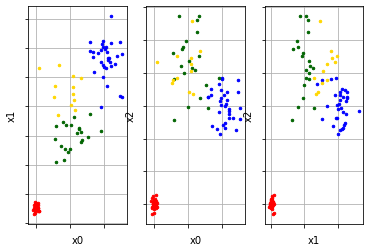

In [101]:

x_means(X,4)

In [31]:
# Prepare initial centers using K-Means++ method.


[array([5.35054598, 3.68771659])]


In [32]:
# Run cluster analysis and obtain results.
xmeans_instance_1.process()
clusters = xmeans_instance_1.get_clusters()
final_centers = xmeans_instance_1.get_centers()

In [33]:
final_centers

[[-4.957007090913727, -5.0115476154679115],
 [1.103508013001677, -1.0740079912115943],
 [1.0081270544323917, 2.3410526260307187],
 [4.899507476842758, 4.9839302284736595]]

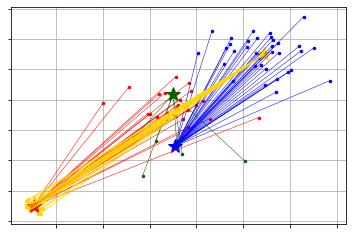

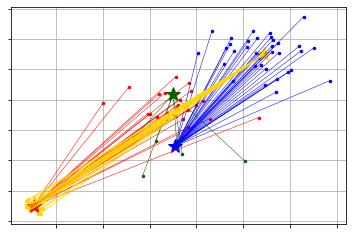

In [62]:
# Visualize obtained results
kmeans_visualizer.show_clusters(X, clusters, final_centers)